# Chess Auto Encoder

- Use HalfKP

TODO:
- Fetch fens
- Convert to HalfKP
- Save to file

In [2]:
import torch
import pandas as pd
import chess
from tqdm import tqdm
import numpy as np
from collections import Counter

from utils import   get_FenBatchProvider, transform
from stockfish_explain.gen_concepts import create_custom_concepts



# Create Dataset

## Fetch fens 

In [3]:
batch_size = 50
num_batch = 1000

FBP = get_FenBatchProvider(batch_size=batch_size)

def fetch_batch():
    fens = next(FBP)
    results = []
    for i, fen in enumerate(fens):
        d = {}
        d['fen'] = fen
        board = chess.Board(fen)
        pieces = dict(Counter([str(v) for v in board.piece_map().values()]))
        d = {**d, **pieces}

        results.append(d)
    return results


data = []
for i in tqdm(range(num_batch)):
    data = data  + fetch_batch()
print(f'Len data: {len(data)}')

df = pd.DataFrame(data).fillna(0)
del data
print(f'df shape: {df.shape}')

100%|██████████| 1000/1000 [00:03<00:00, 280.78it/s]


Len data: 50000
df shape: (50000, 13)


## Add concepts

In [4]:
print(df.shape)
# add concept_dict to df
for idx, row in tqdm(df.iterrows()):
    board = chess.Board(row['fen'])
    concept_dict = create_custom_concepts(board)
    for k, v in concept_dict.items():
        df.at[idx, k] = v   
print(df.shape)

columns_names = {
    'K': 'white_king',
    'k': 'black_king',
    'Q': 'white_queen',
    'q': 'black_queen',
    'R': 'white_rook',
    'r': 'black_rook',
    'B': 'white_bishop',
    'b': 'black_bishop',
    'N': 'white_knight',
    'n': 'black_knight',
    'P': 'white_pawn',
    'p': 'black_pawn',
}


df = df.rename(columns=columns_names)

(50000, 13)


50000it [01:41, 492.51it/s]

(50000, 29)


In [5]:
columns_names = {
    'K': 'white_king',
    'k': 'black_king',
    'Q': 'white_queen',
    'q': 'black_queen',
    'R': 'white_rook',
    'r': 'black_rook',
    'B': 'white_bishop',
    'b': 'black_bishop',
    'N': 'white_knight',
    'n': 'black_knight',
    'P': 'white_pawn',
    'p': 'black_pawn',
}


df = df.rename(columns=columns_names)

In [6]:
# store df in sqlite db for later use
import sqlite3
conn = sqlite3.connect('chess_auto_encoder.db')
df.to_sql('fen_concept_df', conn, if_exists='replace', index=True)
conn.close()

del df


## Convert to HalfKP

# Dataset

# Autoencoder


# Custom Autoencoder

100%|██████████| 30/30 [02:03<00:00,  4.11s/it]


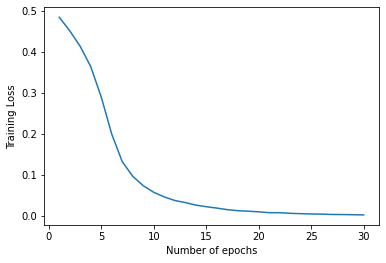

In [11]:
import matplotlib.pyplot as plt
from model import DeepAutoencoder

batch_size = 50
train_loader = get_FenBatchProvider(batch_size=batch_size)
val_loader = get_FenBatchProvider(batch_size=batch_size)


# Instantiating the model and hyperparameters
model = DeepAutoencoder()
criterion = torch.nn.MSELoss()
num_epochs = 30
max_iterations = 100
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

model = model.cuda()

# List that will store the training loss
train_loss = []
  
# Dictionary that will store the
# different images and outputs for 
# various epochs
outputs = {}
  
  
# Training loop starts
for epoch in tqdm(range(num_epochs)):
        
    # Initializing variable for storing 
    # loss
    running_loss = 0
      
    it = 0
    # Iterating over the training dataset
    for batch in train_loader:

        if it == max_iterations:
            break
        it += 1
            
        # Loading image(s) and
        # reshaping it into a 1-d vector
        img = batch
        img = transform(img) 
        img = img.reshape(-1, model.input_size).cuda()
          
        # Generating output
        out = model(img)
          
        # Calculating loss
        loss = criterion(out, img)
          
        # Updating weights according
        # to the calculated loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
          
        # Incrementing loss
        running_loss += loss.item()
      
    # Averaging out loss over entire batch
    running_loss /= batch_size
    train_loss.append(running_loss)
      
    # Storing useful images and
    # reconstructed outputs for the last batch
    outputs[epoch+1] = {'img': img, 'out': out}
  
  
# Plotting the training loss
plt.plot(range(1,num_epochs+1),train_loss)
plt.xlabel("Number of epochs")
plt.ylabel("Training Loss")
plt.show()

# save model to disk
torch.save(model.state_dict(), 'model.pt')


# Fetch activations from encoders

In [7]:
from scipy.sparse import csr_matrix
from tqdm import tqdm
import pandas as pd
import sqlite3
from model import DeepAutoencoder

# load model from disk

model = DeepAutoencoder()
model.load_state_dict(torch.load('model.pt'))

# load df from sqlite db
conn = sqlite3.connect('chess_auto_encoder.db')
df = pd.read_sql_query('select * from fen_concept_df', conn)
conn.close()

activation = {}
def get_output_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

def get_input_activation(name):
    def hook(model, input, output):
        activation['input_'+name] = output.detach()
    return hook

model.encoder_0.register_forward_hook(get_input_activation('encoder_0'))
model.encoder_0.register_forward_hook(get_output_activation('encoder_0'))
model.encoder_1.register_forward_hook(get_output_activation('encoder_1'))
model.encoder_2.register_forward_hook(get_output_activation('encoder_2'))
model.encoder_3.register_forward_hook(get_output_activation('encoder_3'))
model.decoder_0.register_forward_hook(get_output_activation('decoder_0'))
model.decoder_1.register_forward_hook(get_output_activation('decoder_1'))
model.decoder_2.register_forward_hook(get_output_activation('decoder_2'))
model.decoder_3.register_forward_hook(get_output_activation('decoder_3'))

model.cuda()

activation_list = []

for idx, row in tqdm(df.iterrows()):

    data = transform([row['fen']]).cuda()
    output = model(data)

    activations_ = {'index': idx}
    for k, v in activation.items():
        values = v.cpu().numpy()[0]
        if k in ['input_encoder_0', 'decoder_3']:
            # convert values to csr matrix with boolean values
            values = csr_matrix(values, dtype=bool)
        else:
            # convert values to numpy float16
            values = values.astype(np.float16)
        
        activations_[k] = values


    # copy activation and add to activation_list
    activation_list.append(activations_.copy())

#df_activations = pd.DataFrame(activation_list)

50000it [02:45, 302.93it/s]


In [9]:
df_activations = 4

In [8]:
conn = sqlite3.connect('chess_auto_encoder.db')
df_activations.to_sql('activations', conn, if_exists='replace', index=True)
conn.close()

InterfaceError: Error binding parameter 2 - probably unsupported type.

In [14]:
df_activations.head()

,index,encoder_0,encoder_1,encoder_2,encoder_3,decoder_0,decoder_1,decoder_2,decoder_3
0,0,"[0.5723, 0.578, 0.5396, 0.5845, -0.06946, 0.51...","[10.32, -0.1953, 9.4, 10.52, 10.2, -1.096, -0....","[11.36, 9.016, -4.37, 13.08, -1.234, 3.014, 0....","[-6.78, 9.11]","[5.094, 10.42, -3.629, -1.919, 4.38, -4.266, 2...","[-0.12256, -0.4778, 1.023, 2.104, -4.08, 0.149...","[1.246, 2.803, 1.398, -1.455, -0.526, -0.3208,...","(0, 0)\tTrue\n (0, 1)\tTrue\n (0, 2)\tTrue..."
1,1,"[0.3806, 0.3796, 0.3828, 0.3962, -0.03885, 0.3...","[7.14, -0.1421, 6.56, 7.34, 7.145, -0.744, -0....","[7.953, 6.273, -3.057, 9.125, -0.886, 2.07, 0....","[-4.7, 6.36]","[3.404, 7.465, -2.713, -1.528, 2.89, -2.814, 1...","[-0.2274, -0.3984, 0.6265, 1.645, -2.768, 0.19...","[0.967, 1.946, 1.012, -1.0205, -0.4016, -0.262...","(0, 0)\tTrue\n (0, 1)\tTrue\n (0, 2)\tTrue..."
2,2,"[0.04263, 0.0404, 0.03558, 0.0465, -0.007454, ...","[0.746, -0.02776, 0.6953, 0.7993, 0.796, -0.06...","[0.978, 0.614, -0.3496, 0.9478, -0.233, 0.1459...","[-0.4243, 0.693]","[-0.0666, 1.379, -0.82, -0.721, -0.1768, 0.172...","[-0.3958, -0.257, -0.1764, 0.6343, -0.1702, 0....","[0.2993, 0.2686, 0.2418, -0.2225, -0.1368, -0....","(0, 0)\tTrue\n (0, 1)\tTrue\n (0, 2)\tTrue..."
3,3,"[0.241, 0.2646, 0.236, 0.2363, -0.03308, 0.214...","[4.816, -0.0758, 4.45, 4.95, 4.84, -0.519, -0....","[5.418, 4.23, -2.08, 6.17, -0.645, 1.364, 0.00...","[-3.15, 4.31]","[2.148, 5.26, -2.027, -1.236, 1.779, -1.732, 1...","[-0.3044, -0.3389, 0.3306, 1.302, -1.789, 0.22...","[0.758, 1.308, 0.7236, -0.696, -0.31, -0.2183,...","(0, 0)\tTrue\n (0, 1)\tTrue\n (0, 2)\tTrue..."
4,4,"[0.2573, 0.2482, 0.2391, 0.2783, -0.02132, 0.2...","[4.812, -0.1035, 4.41, 4.945, 4.832, -0.5005, ...","[5.41, 4.21, -2.068, 6.145, -0.6484, 1.369, 0....","[-3.143, 4.293]","[2.14, 5.246, -2.021, -1.233, 1.772, -1.726, 1...","[-0.3047, -0.3384, 0.329, 1.299, -1.783, 0.221...","[0.756, 1.304, 0.7217, -0.6934, -0.309, -0.218...","(0, 0)\tTrue\n (0, 1)\tTrue\n (0, 2)\tTrue..."


In [14]:
# import and create sqlite engine

conn = sqlite3.connect('chess_auto_encoder.db')
df_activations.to_sql('activations', conn, if_exists='replace', index=True)
conn.close()


In [ ]:
# import create_engine from sqlalchemy
from sqlalchemy import create_engine
# use sqlalchemy to query the database
engine = create_engine('sqlite:///chess_auto_encoder.db')
df_activations = pd.read_sql_query('SELECT * FROM activations', engine)



In [7]:
df.columns.tolist()

['fen',
 'r',
 'n',
 'b',
 'k',
 'q',
 'p',
 'P',
 'R',
 'N',
 'B',
 'K',
 'Q',
 'white_bishop_pair',
 'black_bishop_pair',
 'white_knight_pair',
 'black_knight_pair',
 'white_double_pawn',
 'black_double_pawn',
 'white_isolated_pawns',
 'black_isolated_pawns',
 'white_connected_rooks',
 'black_connected_rooks',
 'white_has_control_of_open_file',
 'black_has_control_of_open_file',
 'has_contested_open_file',
 'is_forking',
 'can_fork',
 'can_check']

# Concept Model

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import (
    ElasticNet,
    LogisticRegression,
    Ridge,
    RidgeClassifier,
    SGDRegressor,
    LinearRegression,
)
from lightgbm import LGBMClassifier, LGBMRegressor

from imblearn.under_sampling import RandomUnderSampler
# import confusion matrix
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


def classification_cost(y_test, y_pred):
    y_test = np.array(y_test).astype(int)
    y_pred = np.array(y_pred).astype(int)
    residuals = 1 - np.abs(y_pred - y_test)
    return np.mean(residuals) * 2 - 1

test_size = 0.33
input_name = 'encoder_3'
target_name = 'has_contested_open_file'

concept_model = LGBMClassifier()
#concept_model = LogisticRegression()
metric = classification_cost


undersample = RandomUnderSampler(
    sampling_strategy="majority"
)

concept_models = [RidgeClassifier(), LGBMClassifier(), LogisticRegression()]
input_names = ['encoder_0', 'encoder_1', 'encoder_2', 'encoder_3', 'decoder_0', 'decoder_1', 'decoder_2']
target_names = ['has_contested_open_file','white_double_pawn']


results = []
for concept_model in concept_models:
    for input_name in input_names:
        for target_name in target_names:

            model_name = f"{concept_model.__class__.__name__}"

            X = df_activations[input_name].tolist()
            y = df[target_name].tolist()



            # fit and apply the transform
            X, y = undersample.fit_resample(X, list(y * 1))


            # split into train and test sets 
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=test_size, random_state=42, stratify=y
            )



            concept_model.fit(X_train, list(y_train))
            y_pred = concept_model.predict(X_test)

            score = metric(y_test, y_pred)

            # calculate confusion matrix
            matrix = confusion_matrix(y_test, y_pred)

            #print(f'Target value counts: {pd.Series(y_train).value_counts()}')
            #print(f'Target value counts: {pd.Series(y_test).value_counts()}')
            #print(f'input shape: {len(X_train[0])}')
            #print(matrix)
            print(score)

            results_ = {'model_name': model_name,
                        'input_name': input_name, 
                        'target_name': target_name,
                        'score': score, 
                        'size': len(X_train[0])}
            results.append(results_)

df_results = pd.DataFrame(results)
df_results

0.4358717434869739
0.3526570048309179
0.3657314629258517
0.24852388620504562
0.37274549098196386
0.239398819108964
0.14228456913827658
0.2028985507246377
0.1002004008016033
0.096081588835212
0.09819639278557113
0.045625335480407925
0.34468937875751493
0.2356414385399892
0.4358717434869739
0.31025228126677407
0.405811623246493
0.25442834138486314
0.39779559118236474
0.26033279656468067
0.3807615230460921
0.23832528180354262
0.3827655310621243
0.2195383789586689
0.37374749498997994
0.2630166398282341
0.39078156312625256
0.21900161030595822


/home/ap/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.4188376753507015


/home/ap/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.318840579710145
0.38476953907815625
0.2388620504562533
0.3527054108216432
0.22490606548577574
0.09719438877755504
0.10789049919484706
0.08717434869739482
0.016103059581320522
0.10420841683366744
0.056360708534621606
0.3757515030060121
0.24154589371980673


In [49]:
df_results = pd.DataFrame(results)
df_results

,model_name,input_name,target_name,score,size
0,RidgeClassifier,encoder_0,has_contested_open_file,0.435872,1024
1,RidgeClassifier,encoder_0,white_double_pawn,0.352657,1024
2,RidgeClassifier,encoder_1,has_contested_open_file,0.365731,32
3,RidgeClassifier,encoder_1,white_double_pawn,0.248524,32
4,RidgeClassifier,encoder_2,has_contested_open_file,0.372745,8
5,RidgeClassifier,encoder_2,white_double_pawn,0.239399,8
6,RidgeClassifier,encoder_3,has_contested_open_file,0.142285,2
7,RidgeClassifier,encoder_3,white_double_pawn,0.202899,2
8,RidgeClassifier,decoder_0,has_contested_open_file,0.100200,8
9,RidgeClassifier,decoder_0,white_double_pawn,0.096082,8


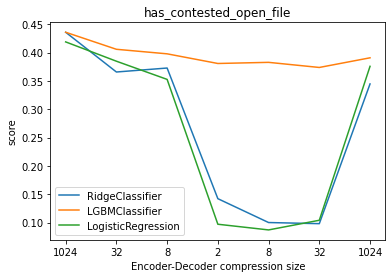

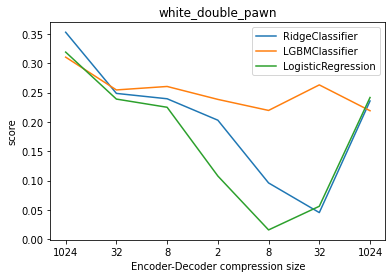

In [52]:
for target_name in df_results.target_name.unique():
    df_results_ = df_results[df_results.target_name == target_name]
    for model_name  in df_results_.model_name.unique():
        # plot scores
        plt.plot(range(len(df_results_[df_results_.model_name == model_name])), df_results_[df_results_.model_name == model_name].score, label=model_name)

    # set x ticks as size   
    plt.xticks(range(len(df_results_[df_results_.model_name == model_name])), df_results_[df_results_.model_name == model_name]['size'].astype(str))
    plt.title(target_name)
    plt.ylabel('score')
    plt.xlabel('Encoder-Decoder compression size')
    plt.legend()
    plt.show()